### Import Libraries

In [28]:
import tensorflow as tf
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D, Conv2D, MaxPooling2D, Flatten
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import numpy as np
from keras.preprocessing import image 
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix

### Change Path to Working Directory

In [3]:
import os
print("Current working directory:", os.getcwd())
os.chdir(r"D:\Labmentix\Aerial-Object-Detection-Bird-vs-Drone")
print("Now in:", os.getcwd())

Current working directory: C:\Users\artis
Now in: D:\Labmentix\Aerial-Object-Detection-Bird-vs-Drone


### Define dataset parameters


In [4]:
image_height = 224
image_width = 224
num_channels = 3
batch_size = 32
num_classes = 2

### Get Image From each Directory ( Visualization)


In [6]:
data_path=r'dataset'
image_classes = os.listdir(data_path)
print(image_classes)

['bird', 'drone']


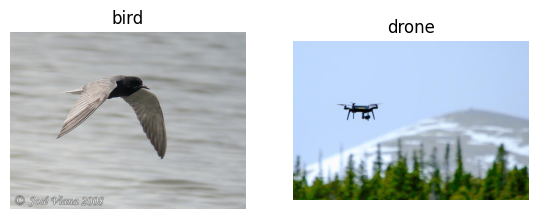

In [7]:
def plot_image(image_classes):
    plt.figure(figsize=(14 , 14))
    
    for i , category in enumerate(image_classes):
        image_path = data_path + '/' + category
        images_in_folder = os.listdir(image_path)
        
        first_image = images_in_folder[0]
        first_image_path = image_path + '/' + first_image 
        
        img= image.load_img(first_image_path)
        img_array = image.img_to_array(img) / 255
        
        plt.subplot(4 , 4 , i+1)
        plt.imshow(img_array)
        plt.title(category)
        plt.axis('off')
    plt.show()
plot_image(image_classes)

In [8]:
# Data Augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split=0.2  # Split for training and validation
)

### Preprocessing Data & Split Data into Train & Test


In [9]:
train_data = train_datagen.flow_from_directory(
    r'dataset',  
    target_size=(image_height, image_width),
    batch_size=batch_size,
    class_mode='sparse',
    subset='training'
)

Found 3284 images belonging to 2 classes.


In [10]:
val_data = train_datagen.flow_from_directory(
    r'dataset',  
    target_size=(image_height, image_width),
    batch_size=batch_size,
    class_mode='sparse',
    subset='validation'
)

Found 820 images belonging to 2 classes.


In [12]:
test_data = train_datagen.flow_from_directory(
    r'dataset',  
    target_size=(image_height, image_width),
    batch_size=batch_size,
    class_mode='sparse',
    subset='validation'
)

Found 820 images belonging to 2 classes.


### Load the pre-trained MobileNetV2 model


In [13]:
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(image_height, image_width, num_channels))

In [14]:
#Freeze the base model's layers to retain pre-trained weights
base_model.trainable = False

# Build the model

#### Custom CNN Model

In [15]:
cnn_model = Sequential([
    Conv2D(32, (3,3), activation='relu', input_shape=(224,224,3)),
    MaxPooling2D(),
    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D(),
    Conv2D(128, (3,3), activation='relu'),
    MaxPooling2D(),

    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.3),
    Dense(1, activation='sigmoid')  # Bird or Drone
])
cnn_model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)
cnn_model.summary()

C:\Users\artis\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 222, 222, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 111, 111, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 109, 109, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 54, 54, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 52, 52, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 26, 26, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 86528)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │      11,075,712 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 11,169,089 (42.61 MB)

 Trainable params: 11,169,089 (42.61 MB)

 Non-trainable params: 0 (0.00 B)

In [16]:
cnn_history = cnn_model.fit(
    train_data,
    validation_data=val_data,
    epochs=10
)

Epoch 1/10
103/103 ━━━━━━━━━━━━━━━━━━━━ 152s 1s/step - accuracy: 0.7789 - loss: 0.5397 - val_accuracy: 0.6634 - val_loss: 0.5811
Epoch 2/10
103/103 ━━━━━━━━━━━━━━━━━━━━ 129s 1s/step - accuracy: 0.8313 - loss: 0.3917 - val_accuracy: 0.7341 - val_loss: 0.5607
Epoch 3/10
103/103 ━━━━━━━━━━━━━━━━━━━━ 146s 1s/step - accuracy: 0.8484 - loss: 0.3501 - val_accuracy: 0.7220 - val_loss: 0.5383
Epoch 4/10
103/103 ━━━━━━━━━━━━━━━━━━━━ 136s 1s/step - accuracy: 0.8685 - loss: 0.3151 - val_accuracy: 0.6561 - val_loss: 0.5639
Epoch 5/10
103/103 ━━━━━━━━━━━━━━━━━━━━ 142s 1s/step - accuracy: 0.8812 - loss: 0.2902 - val_accuracy: 0.7927 - val_loss: 0.4415
Epoch 6/10
103/103 ━━━━━━━━━━━━━━━━━━━━ 125s 1s/step - accuracy: 0.8904 - loss: 0.2651 - val_accuracy: 0.6220 - val_loss: 0.6201
Epoch 7/10
103/103 ━━━━━━━━━━━━━━━━━━━━ 3726s 37s/step - accuracy: 0.8995 - loss: 0.2602 - val_accuracy: 0.7622 - val_loss: 0.5429
Epoch 8/10
103/103 ━━━━━━━━━━━━━━━━━━━━ 3758s 37s/step - accuracy: 0.9205 - loss: 0.2154 - val_

#### Mobilenet Model

In [17]:
mobilenet_model = Sequential([
    base_model,  # Add the pre-trained model as the base
    GlobalAveragePooling2D(),  # Add a pooling layer
    Dense(128, activation='relu'),  # Fully connected layer
    Dropout(0.3),  # Dropout for regularization
    Dense(num_classes, activation='softmax')  # Output layer
])

# Compile the Model
mobilenet_model.compile(optimizer=Adam(learning_rate=0.001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
mobilenet_model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224 (Functional)    │ (None, 7, 7, 1280)          │       2,257,984 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 1280)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 128)                 │         163,968 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 2)                   │             258 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,422,210 (9.24 MB)

 Trainable params: 164,226 (641.51 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

Callbacks

In [18]:
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3)
model_checkpoint = ModelCheckpoint('best_model.keras', monitor='val_loss', save_best_only=True)

### Train the Model


In [19]:
mobilenet_history = mobilenet_model.fit(
    train_data,
    validation_data=val_data,
    epochs=10,
    callbacks=[early_stopping, lr_scheduler, model_checkpoint]
)

Epoch 1/10
103/103 ━━━━━━━━━━━━━━━━━━━━ 334s 3s/step - accuracy: 0.9220 - loss: 0.2007 - val_accuracy: 0.8695 - val_loss: 0.3831 - learning_rate: 0.0010
Epoch 2/10
103/103 ━━━━━━━━━━━━━━━━━━━━ 286s 3s/step - accuracy: 0.9680 - loss: 0.0947 - val_accuracy: 0.8817 - val_loss: 0.3124 - learning_rate: 0.0010
Epoch 3/10
103/103 ━━━━━━━━━━━━━━━━━━━━ 146s 1s/step - accuracy: 0.9705 - loss: 0.0863 - val_accuracy: 0.9085 - val_loss: 0.2780 - learning_rate: 0.0010
Epoch 4/10
103/103 ━━━━━━━━━━━━━━━━━━━━ 181s 1s/step - accuracy: 0.9772 - loss: 0.0634 - val_accuracy: 0.9159 - val_loss: 0.2564 - learning_rate: 0.0010
Epoch 5/10
103/103 ━━━━━━━━━━━━━━━━━━━━ 1994s 1s/step - accuracy: 0.9717 - loss: 0.0744 - val_accuracy: 0.9037 - val_loss: 0.2713 - learning_rate: 0.0010
Epoch 6/10
103/103 ━━━━━━━━━━━━━━━━━━━━ 122s 1s/step - accuracy: 0.9820 - loss: 0.0499 - val_accuracy: 0.9171 - val_loss: 0.2638 - learning_rate: 0.0010
Epoch 7/10
103/103 ━━━━━━━━━━━━━━━━━━━━ 51398s 1s/step - accuracy: 0.9811 - loss:

### Evaluate The Model Accuracy & Visualize Results

In [20]:
custom_eval = cnn_model.evaluate(test_data)
mobilenet_eval = mobilenet_model.evaluate(test_data)

print("\n Custom CNN - Loss & Accuracy:", custom_eval)
print("\n MobileNetV2 - Loss & Accuracy:", mobilenet_eval)

26/26 ━━━━━━━━━━━━━━━━━━━━ 39s 1s/step - accuracy: 0.7573 - loss: 0.4651
26/26 ━━━━━━━━━━━━━━━━━━━━ 44s 2s/step - accuracy: 0.9280 - loss: 0.2522

 Custom CNN - Loss & Accuracy: [0.46512213349342346, 0.757317066192627]

 MobileNetV2 - Loss & Accuracy: [0.25217878818511963, 0.9280487895011902]


In [21]:
def plot_training_history(history):
    plt.figure(figsize=(12, 5))
    
    # Accuracy Plot
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    
    # Loss Plot
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    
    plt.tight_layout()
    plt.show()

### Training History Plot

CNN

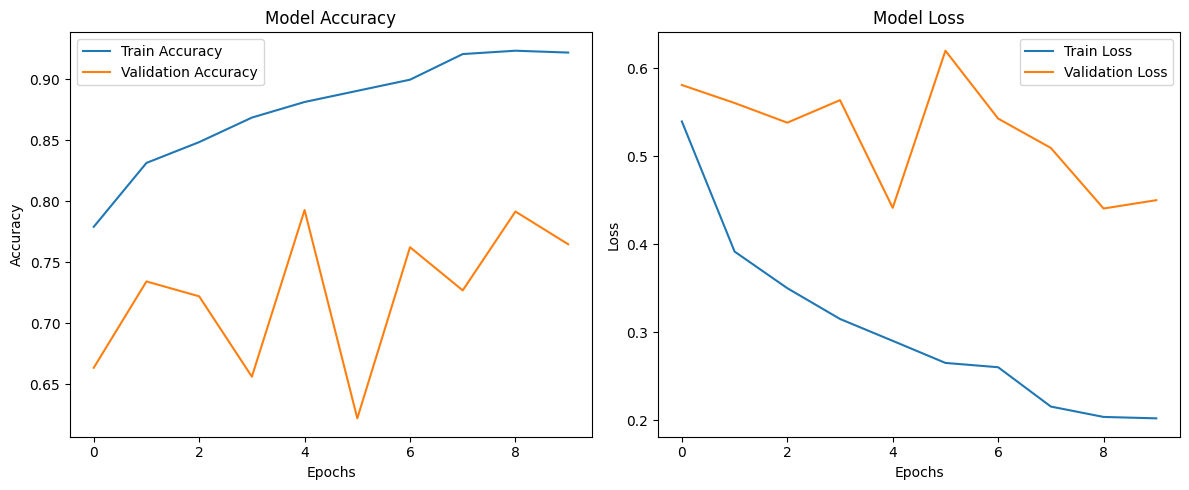

In [22]:
plot_training_history(cnn_history)

Mobilenet

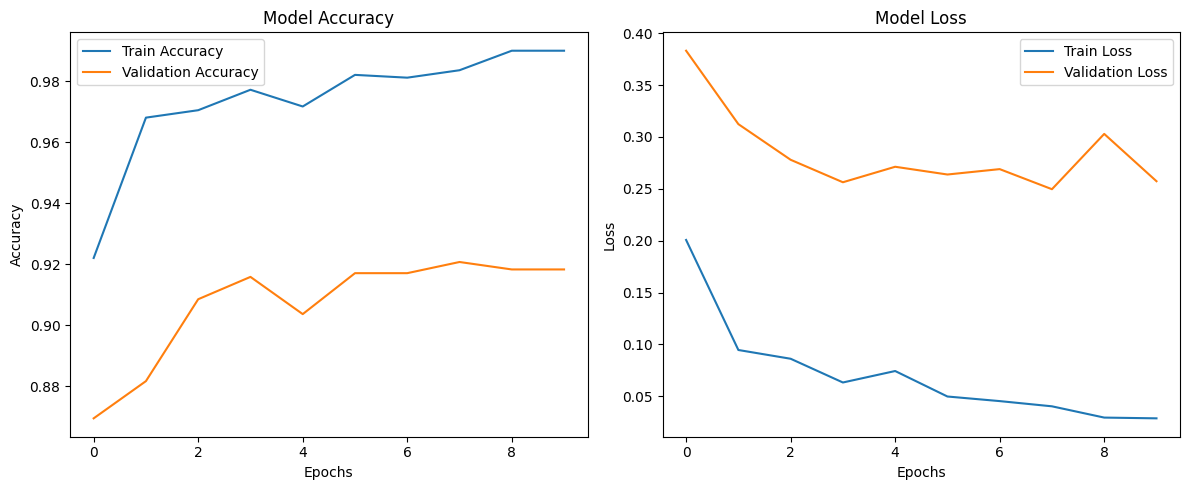

In [23]:
plot_training_history(mobilenet_history)

### Classification Report & Confusion Matrix

CNN

26/26 ━━━━━━━━━━━━━━━━━━━━ 34s 1s/step

Custom CNN Classification Report:

              precision    recall  f1-score   support

           0       0.37      0.38      0.37       321
           1       0.59      0.59      0.59       499

    accuracy                           0.50       820
   macro avg       0.48      0.48      0.48       820
weighted avg       0.51      0.50      0.51       820



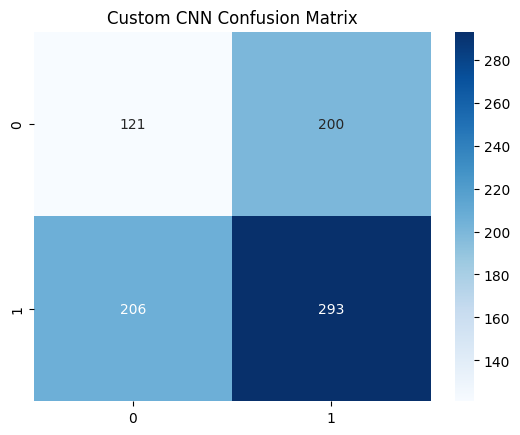

In [25]:
y_true = test_data.classes
y_pred_custom = (cnn_model.predict(test_data) > 0.5).astype("int32")

print("\nCustom CNN Classification Report:\n")
print(classification_report(y_true, y_pred_custom))

cm = confusion_matrix(y_true, y_pred_custom)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title("Custom CNN Confusion Matrix")
plt.show()


### Comparison Summary

In [36]:
print(f"Custom CNN Accuracy:     {custom_eval[1]*100:.2f}%")
print(f"MobileNetV2 Accuracy:    {mobilenet_eval[1]*100:.2f}%")

improvement = (mobilenet_eval[1] - custom_eval[1]) * 100
print(f"\nMobileNet improves accuracy by: {improvement:.2f}%")

Custom CNN Accuracy:     75.73%
MobileNetV2 Accuracy:    92.80%

MobileNet improves accuracy by: 17.07%


### Save Model as h5

In [31]:
# Save the final trained model
mobilenet_model.save("models/mobilenet_bird_drone_classifier.keras")